In [90]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import seaborn as sns

<center><h1>Przygotowanie danych</h1></center>

In [91]:
class DataPreparation():
    @staticmethod
    def load_and_clear_data(name_of_file: str="output_projekt.csv") -> pd.DataFrame:
        dfAntropo = pd.read_csv('antropo_out.csv', sep=';').drop(["CisnienieKrwiSkurczowe","CisnienieKrwiRozkurczowe","TetnoKrwi"], axis=1)
        dfAntropo = dfAntropo.drop([col for col in dfAntropo.columns if col.startswith("Fald") or col.startswith("Glebokosc") or col.startswith("Szerokosc")], axis=1)
        #Wzięcie tych kolumn które nas interesują 
        dfInbody = pd.read_csv('inbody_out.csv', sep=',')[["id","DataBadania","FFM_FatFreeMass_", "Sex"]]
        #Zmiana formatu daty badania na spójny z danymi antropo (usunięcie godzin)
        dfInbody["DataBadania"] = dfInbody["DataBadania"].apply(lambda x: x.split('.')[0] + '.' + x.split('.')[1] + '.' + x.split('.')[2])
        #Połączenie i wyrzucenie zbędnych kolumn
        dfMerged = pd.merge(dfAntropo, dfInbody, on=['id', 'DataBadania'], how="outer").drop(['id', 'DataBadania', 'Unnamed: 0', 'data.badania'], axis=1)
        #Zmiana płci na 0 i 1 
        dfMerged.loc[dfMerged["Sex"]=="M", "Sex"] = 1
        dfMerged.loc[dfMerged["Sex"]=="F", "Sex"] = 0
        #Pozbycie się nan
        dfMerged = dfMerged.dropna()
        dfMerged.to_csv(name_of_file)
        return dfMerged
    @staticmethod
    def load_previously_prepared_data(name_of_file: str="output_projekt.csv") -> pd.DataFrame:
        return pd.read_csv(name_of_file)
    @staticmethod
    def train_test_split_without_sex_split(df: pd.DataFrame) -> tuple:
        y = df["FFM_FatFreeMass_"]
        X = df.drop(["FFM_FatFreeMass_", "Sex"], axis=1)
        return train_test_split(X, y, test_size=0.2, random_state=0)
    @staticmethod
    def train_test_split_with_sex_split(df: pd.DataFrame, is_man: int = 1) -> tuple:
        X = df[df["Sex"]==is_man].drop("FFM_FatFreeMass_", axis=1)
        y = df[df["Sex"]==is_man]["FFM_FatFreeMass_"]
        return train_test_split(X, y, test_size=0.2, random_state=0)
    @staticmethod
    def plot_corr_heat_map(df: pd.DataFrame) -> None:
      sns.heatmap(df.corr(), annot=True)


In [92]:
class DataPrediction():
   @staticmethod
   def linear_regression(train_test_tuple, data_type: str = "") -> None: 
      X_train, X_test, y_train, y_test = train_test_tuple
      linearReg = LinearRegression()
      linearReg.fit(X_train, y_train)
      print(f"Wyniki dla: {data_type}")
      print(f"score: {linearReg.score(X_test, y_test)}\n"
            f"predykcja:\n{linearReg.predict(X_test.head())}\n"
            f"dane:\n{y_test.head()}")
   @staticmethod
   def tree_regression(train_test_tuple: tuple, data_type: str) -> None:
      X_train, X_test, y_train, y_test = train_test_tuple
      treeReg = DecisionTreeRegressor(random_state=0)
      param_grid= {"criterion":["squared_error", "friedman_mse", "absolute_error", "poisson"],
                   'max_depth':[1,3,5,7,9,11,13,15,None]}
      grid = GridSearchCV(treeReg, param_grid, cv=5)
      grid.fit(X_train, y_train)
      print(f"Wyniki dla: {data_type}")
      print(f"najlepsze parametry: {grid.best_params_}\n"
            f"score: {grid.score(X_test, y_test)}\n"
            f"predykcja:\n{grid.predict(X_test.head())}\n"
            f"dane:\n{y_test.head()}")



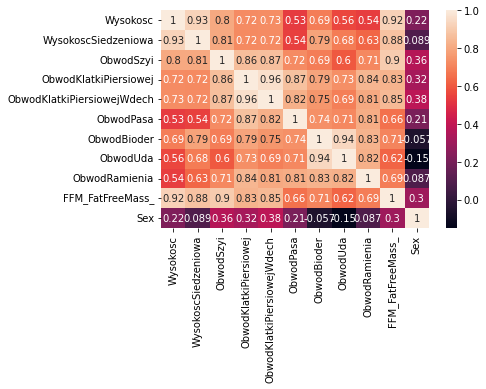

In [93]:
df = DataPreparation.load_and_clear_data()
DataPreparation.plot_corr_heat_map(df)

<h1><center>Bez podziału na płci

<h2><center>Regresja liniowa

In [94]:
DataPrediction.linear_regression(DataPreparation.train_test_split_without_sex_split(df),"Bez podziału na płci")

Wyniki dla: Bez podziału na płci
score: 0.9143871900387873
predykcja:
[58.9176854  45.70460206 31.83949219 38.91186089 43.59865042]
dane:
2     57.9
13    41.8
53    31.4
41    40.8
86    41.2
Name: FFM_FatFreeMass_, dtype: float64


<center><h2>DecisionTreeRegressor</h2></center>

In [95]:
DataPrediction.tree_regression(DataPreparation.train_test_split_without_sex_split(df),"Bez podziału na płci")

Wyniki dla: Bez podziału na płci
najlepsze parametry: {'criterion': 'absolute_error', 'max_depth': 9}
score: 0.9133576456250911
predykcja:
[65.3 38.7 31.5 37.1 38.7]
dane:
2     57.9
13    41.8
53    31.4
41    40.8
86    41.2
Name: FFM_FatFreeMass_, dtype: float64


<center><h1>Podział danych według płci</h1></center>

In [96]:
DataPrediction.linear_regression(DataPreparation.train_test_split_with_sex_split(df, 0),"regresja liniowa kobiet")

Wyniki dla: regresja liniowa kobiet
score: 0.9079786696338932
predykcja:
[23.01247787 32.20028366 30.07745202 39.80323133 39.46792324]
dane:
67    23.1
77    34.4
57    27.7
11    40.4
18    39.2
Name: FFM_FatFreeMass_, dtype: float64


In [97]:
DataPrediction.linear_regression(DataPreparation.train_test_split_with_sex_split(df, 1),"regresja liniowa mężczyzn")

Wyniki dla: regresja liniowa mężczyzn
score: 0.8969907686838426
predykcja:
[42.74590303 30.80499522 28.53293573 54.10386367 47.76219257]
dane:
55    45.8
63    27.3
59    27.9
4     45.2
35    48.9
Name: FFM_FatFreeMass_, dtype: float64


In [98]:
DataPrediction.tree_regression(DataPreparation.train_test_split_with_sex_split(df, 0),"regresja drzewa decyzyjnego kobiet")

Wyniki dla: regresja drzewa decyzyjnego kobiet
najlepsze parametry: {'criterion': 'absolute_error', 'max_depth': 1}
score: 0.784695227335015
predykcja:
[25.25 39.6  25.25 39.6  39.6 ]
dane:
67    23.1
77    34.4
57    27.7
11    40.4
18    39.2
Name: FFM_FatFreeMass_, dtype: float64


In [99]:
DataPrediction.tree_regression(DataPreparation.train_test_split_with_sex_split(df, 1),"regresja drzewa decyzyjnego mężczyzn")

Wyniki dla: regresja drzewa decyzyjnego mężczyzn
najlepsze parametry: {'criterion': 'absolute_error', 'max_depth': 9}
score: 0.782768503841201
predykcja:
[39.  31.9 33.1 48.5 40.4]
dane:
55    45.8
63    27.3
59    27.9
4     45.2
35    48.9
Name: FFM_FatFreeMass_, dtype: float64
